# Linear Regression Benchmark: causers vs statsmodels vs pyfixest

This notebook demonstrates that `causers.linear_regression` produces results 
equivalent to reference packages while achieving significant speedup.

## Benchmark Dimensions

This benchmark covers:
1. **Observations (n)**: 1,000 | 10,000 | 100,000
2. **Control Variables (p)**: 2 | 10 | 50
3. **Standard Error Types**:
   - HC3: Heteroskedasticity-consistent standard errors
   - Clustered (balanced): 100 clusters with equal observations per cluster
   - Clustered (imbalanced): 100 clusters with varying observations per cluster
4. **Fixed Effects (FE)**:
   - FE=0: No fixed effects (compare vs statsmodels + pyfixest)
   - FE=1: One-way fixed effects (compare vs pyfixest only)
   - FE=2: Two-way fixed effects (compare vs pyfixest only)

**Note**: statsmodels doesn't support fixed effects absorption, so FE>0 benchmarks only compare against pyfixest.

**References**:
- Seabold & Perktold. "statsmodels: Econometric and statistical modeling with python." 2010.
- pyfixest: Python implementation of fixest (R package)

## Prerequisites

Required packages:
- `causers` (the package under test)
- `statsmodels` (for parity comparison, FE=0 only)
- `pyfixest` (for parity comparison, all FE levels)
- `numpy`, `polars` (data generation)
- `matplotlib` (visualization)

Install reference packages:
```bash
pip install statsmodels pyfixest matplotlib
```

## Methodology

### Parity Tests
- Compare coefficient estimates with rtol=1e-6
- Compare HC3 standard errors with rtol=1e-6
- Compare intercept and intercept SE with rtol=1e-6
- Tests ported from `tests/test_linear_regression.py`

### Timing Benchmarks
- Warm-up: 1 iteration (discarded)
- Measurement: 5 iterations
- Reported: Median execution time
- Speedup: reference_time / causers_time

### Fixed Effects Notes
- pyfixest uses `vcov="HC3"` for FE=0, `vcov="hetero"` (HC1) for FE>0
- pyfixest uses `lean=True` to avoid storing unnecessary objects for fair comparison

In [1]:
"""Environment setup and version printing."""
import sys
import platform
import warnings
from typing import Callable, Dict, Any, List, Tuple, Optional

import numpy as np
import polars as pl
import pandas as pd

# Import causers
import causers
from causers import linear_regression
print(f"causers version: {causers.__version__}")

# Import statsmodels with graceful fallback
try:
    import statsmodels.api as sm
    HAS_STATSMODELS = True
    print(f"statsmodels version: {sm.__version__}")
except ImportError:
    HAS_STATSMODELS = False
    sm = None
    print("⚠️ statsmodels not installed. FE=0 parity tests will be limited.")
    print("Install with: pip install statsmodels")

# Import pyfixest with graceful fallback
try:
    import pyfixest as pf
    HAS_PYFIXEST = True
    print(f"pyfixest version: {pf.__version__}")
except ImportError:
    HAS_PYFIXEST = False
    pf = None
    print("⚠️ pyfixest not installed. Fixed effects benchmarks will be skipped.")
    print("Install with: pip install pyfixest")

# Import matplotlib for visualization
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("⚠️ matplotlib not installed. Visualizations will be skipped.")

print(f"\nPython {sys.version}")
print(f"Platform: {platform.platform()}")

causers version: 0.6.0


statsmodels version: 0.14.6


pyfixest version: 0.40.1

Python 3.11.2 (main, Apr 28 2025, 14:11:48) [GCC 12.2.0]
Platform: Linux-6.12.54-linuxkit-aarch64-with-glibc2.36


In [2]:
"""Timing and comparison helper functions."""
import time

SEED = 42

def time_function(func: Callable, *args, n_iter: int = 5, 
                  warmup: int = 1, **kwargs) -> Dict[str, Any]:
    """Time function execution with warmup."""
    # Warmup
    for _ in range(warmup):
        func(*args, **kwargs)
    
    # Timed runs
    times = []
    result = None
    for _ in range(n_iter):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = (time.perf_counter() - start) * 1000  # ms
        times.append(elapsed)
    
    return {
        "result": result,
        "median_ms": np.median(times),
        "iqr_ms": np.percentile(times, 75) - np.percentile(times, 25)
    }

def check_parity(name: str, causers_val: float, ref_val: float, 
                 rtol: float = 1e-6) -> Dict[str, str]:
    """Check numerical parity and return result dict."""
    passed = np.isclose(causers_val, ref_val, rtol=rtol, atol=0)
    return {
        "Metric": name,
        "causers": f"{causers_val:.6f}",
        "reference": f"{ref_val:.6f}",
        "Tolerance": f"rtol={rtol}",
        "Status": "✅ PASS" if passed else "❌ FAIL"
    }

print("Helper functions defined.")

Helper functions defined.


In [3]:
"""Data generation functions for comprehensive benchmarks."""

def generate_linear_regression_data(
    n_obs: int, 
    n_vars: int, 
    cluster_type: Optional[str] = None,
    num_fe: int = 0,
    seed: int = SEED
) -> Tuple[pl.DataFrame, np.ndarray, np.ndarray, Optional[np.ndarray]]:
    """Generate data for comprehensive linear regression benchmark.
    
    Args:
        n_obs: Number of observations
        n_vars: Number of control variables
        cluster_type: None for HC3, "balanced" for balanced clusters, "imbalanced" for imbalanced
        num_fe: Number of fixed effect columns (0, 1, or 2)
        seed: Random seed
    
    Returns:
        Tuple of (polars DataFrame, X numpy array, y numpy array, cluster array or None)
    """
    np.random.seed(seed)
    
    # Determine FE group counts based on n_obs
    n_fe1_groups = min(100, max(10, n_obs // 100)) if num_fe >= 1 else 0
    n_fe2_groups = min(50, max(5, n_obs // 200)) if num_fe >= 2 else 0
    
    # Generate fixed effect IDs and effects
    fe1_effects = 0.0
    fe2_effects = 0.0
    
    if num_fe >= 1:
        fe1_ids = np.random.randint(0, n_fe1_groups, size=n_obs)
        fe1_values = np.random.uniform(-2, 2, size=n_fe1_groups)
        fe1_effects = fe1_values[fe1_ids]
    
    if num_fe >= 2:
        fe2_ids = np.random.randint(0, n_fe2_groups, size=n_obs)
        fe2_values = np.random.uniform(-1, 1, size=n_fe2_groups)
        fe2_effects = fe2_values[fe2_ids]
    
    # Generate X variables
    x_data = {f"x{i}": np.random.randn(n_obs) for i in range(n_vars)}
    
    # Generate y with relationship to X and fixed effects
    y = sum(x_data.values()) + fe1_effects + fe2_effects + np.random.randn(n_obs) * 0.5
    
    df = pl.DataFrame({"y": y, **x_data})
    
    # Add fixed effect columns
    if num_fe >= 1:
        df = df.with_columns(pl.Series("fe1", fe1_ids))
    if num_fe >= 2:
        df = df.with_columns(pl.Series("fe2", fe2_ids))
    
    # Create numpy X array for statsmodels
    X = np.column_stack(list(x_data.values()))
    
    cluster_ids = None
    if cluster_type is not None:
        n_clusters = 100
        if cluster_type == "balanced":
            cluster_ids = np.repeat(range(n_clusters), n_obs // n_clusters)
            remainder = n_obs - len(cluster_ids)
            if remainder > 0:
                cluster_ids = np.concatenate([cluster_ids, np.arange(remainder)])
        else:  # imbalanced
            cluster_sizes = []
            for i in range(n_clusters):
                size = n_obs // n_clusters
                if i < 10:  # First 10 clusters are 5x larger
                    size *= 5
                cluster_sizes.append(size)
            cluster_sizes = np.array(cluster_sizes)
            cluster_sizes = (cluster_sizes / cluster_sizes.sum() * n_obs).astype(int)
            cluster_sizes[-1] = n_obs - cluster_sizes[:-1].sum()
            cluster_ids = np.repeat(range(n_clusters), cluster_sizes)
        
        df = df.with_columns(pl.Series("cluster", cluster_ids[:n_obs]))
    
    return df, X, np.array(y), cluster_ids


# Linear regression benchmark configurations
# (n_obs, n_vars, se_type, cluster_type, num_fe, label)
LINEAR_REGRESSION_CONFIGS = [
    # === No Fixed Effects (FE=0) - Compare all three ===
    (1000, 2, "hc3", None, 0, "1K obs, 2 vars, HC3, FE=0"),
    (10000, 2, "hc3", None, 0, "10K obs, 2 vars, HC3, FE=0"),
    (100000, 2, "hc3", None, 0, "100K obs, 2 vars, HC3, FE=0"),
    (10000, 10, "hc3", None, 0, "10K obs, 10 vars, HC3, FE=0"),
    (10000, 50, "hc3", None, 0, "10K obs, 50 vars, HC3, FE=0"),
    
    # === One-way Fixed Effects (FE=1) - pyfixest only ===
    (1000, 2, "hc3", None, 1, "1K obs, 2 vars, HC3, FE=1"),
    (10000, 2, "hc3", None, 1, "10K obs, 2 vars, HC3, FE=1"),
    (100000, 2, "hc3", None, 1, "100K obs, 2 vars, HC3, FE=1"),
    
    # === Two-way Fixed Effects (FE=2) - pyfixest only ===
    (1000, 2, "hc3", None, 2, "1K obs, 2 vars, HC3, FE=2"),
    (10000, 2, "hc3", None, 2, "10K obs, 2 vars, HC3, FE=2"),
    (100000, 2, "hc3", None, 2, "100K obs, 2 vars, HC3, FE=2"),
]

print(f"Defined {len(LINEAR_REGRESSION_CONFIGS)} benchmark configurations")

Defined 11 benchmark configurations


## Parity Tests

Tests ported from `tests/test_linear_regression.py`:
- `test_hc3_matches_statsmodels_single_covariate`
- `test_hc3_matches_statsmodels_multiple_covariates`
- `test_hc3_matches_statsmodels_no_intercept`

In [4]:
"""Parity Test 1: Single covariate with intercept."""

if not HAS_STATSMODELS:
    print("⚠️ Skipping parity tests - statsmodels not installed")
    parity_results_1 = []
else:
    print("=" * 60)
    print("PARITY TEST 1: Single Covariate with Intercept")
    print("=" * 60)
    
    np.random.seed(SEED)
    n = 50
    x = np.random.randn(n)
    y = 2 * x + 1 + np.random.randn(n) * 0.5
    
    X_sm = sm.add_constant(x)
    model = sm.OLS(y, X_sm).fit()
    hc3 = model.get_robustcov_results(cov_type='HC3')
    
    df = pl.DataFrame({"x": x, "y": y})
    result = linear_regression(df, "x", "y")
    
    parity_results_1 = [
        check_parity("Coefficient", result.coefficients[0], hc3.params[1], rtol=1e-6),
        check_parity("Intercept", result.intercept, hc3.params[0], rtol=1e-6),
        check_parity("SE(coef) HC3", result.standard_errors[0], hc3.bse[1], rtol=1e-6),
        check_parity("SE(intercept) HC3", result.intercept_se, hc3.bse[0], rtol=1e-6),
    ]
    print(pd.DataFrame(parity_results_1).to_string(index=False))

PARITY TEST 1: Single Covariate with Intercept
           Metric  causers reference  Tolerance Status
      Coefficient 2.051538  2.051538 rtol=1e-06 ✅ PASS
        Intercept 1.020511  1.020511 rtol=1e-06 ✅ PASS
     SE(coef) HC3 0.055949  0.055949 rtol=1e-06 ✅ PASS
SE(intercept) HC3 0.061842  0.061842 rtol=1e-06 ✅ PASS


In [5]:
"""Parity Test 2: Multiple covariates with intercept."""
if not HAS_STATSMODELS:
    print("⚠️ Skipping parity tests - statsmodels not installed")
    parity_results_2 = []
else:
    print("=" * 60)
    print("PARITY TEST 2: Multiple Covariates with Intercept")
    print("=" * 60)
    
    np.random.seed(SEED)
    n = 100
    x1 = np.random.randn(n)
    x2 = np.random.randn(n)
    y = 2 * x1 + 3 * x2 + 1 + np.random.randn(n) * 0.5
    
    X = np.column_stack([x1, x2])
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    hc3 = model.get_robustcov_results(cov_type='HC3')
    
    df = pl.DataFrame({"x1": x1, "x2": x2, "y": y})
    result = linear_regression(df, ["x1", "x2"], "y")
    
    parity_results_2 = [
        check_parity("Coefficient x1", result.coefficients[0], hc3.params[1], rtol=1e-6),
        check_parity("Coefficient x2", result.coefficients[1], hc3.params[2], rtol=1e-6),
        check_parity("Intercept", result.intercept, hc3.params[0], rtol=1e-6),
        check_parity("SE(x1) HC3", result.standard_errors[0], hc3.bse[1], rtol=1e-6),
        check_parity("SE(x2) HC3", result.standard_errors[1], hc3.bse[2], rtol=1e-6),
        check_parity("SE(intercept) HC3", result.intercept_se, hc3.bse[0], rtol=1e-6),
    ]
    print(pd.DataFrame(parity_results_2).to_string(index=False))

PARITY TEST 2: Multiple Covariates with Intercept
           Metric  causers reference  Tolerance Status
   Coefficient x1 2.113045  2.113045 rtol=1e-06 ✅ PASS
   Coefficient x2 2.993862  2.993862 rtol=1e-06 ✅ PASS
        Intercept 1.044324  1.044324 rtol=1e-06 ✅ PASS
       SE(x1) HC3 0.059637  0.059637 rtol=1e-06 ✅ PASS
       SE(x2) HC3 0.054653  0.054653 rtol=1e-06 ✅ PASS
SE(intercept) HC3 0.055789  0.055789 rtol=1e-06 ✅ PASS


In [6]:
"""Parity Test 3: Single covariate without intercept."""
if not HAS_STATSMODELS:
    print("⚠️ Skipping parity tests - statsmodels not installed")
    parity_results_3 = []
else:
    print("=" * 60)
    print("PARITY TEST 3: Single Covariate without Intercept")
    print("=" * 60)
    
    np.random.seed(SEED)
    n = 50
    x = np.random.randn(n)
    y = 2 * x + np.random.randn(n) * 0.5
    
    X_sm = x.reshape(-1, 1)
    model = sm.OLS(y, X_sm).fit()
    hc3 = model.get_robustcov_results(cov_type='HC3')
    
    df = pl.DataFrame({"x": x, "y": y})
    result = linear_regression(df, "x", "y", include_intercept=False)
    
    parity_results_3 = [
        check_parity("Coefficient", result.coefficients[0], hc3.params[0], rtol=1e-6),
        check_parity("SE(coef) HC3", result.standard_errors[0], hc3.bse[0], rtol=1e-6),
    ]
    print(f"Intercept is None: {result.intercept is None}")
    print(pd.DataFrame(parity_results_3).to_string(index=False))

PARITY TEST 3: Single Covariate without Intercept
Intercept is None: True
      Metric  causers reference  Tolerance Status
 Coefficient 2.046428  2.046428 rtol=1e-06 ✅ PASS
SE(coef) HC3 0.056759  0.056759 rtol=1e-06 ✅ PASS


## Comprehensive Timing Benchmarks

This section runs benchmarks across all configurations:
- **FE=0**: causers vs statsmodels vs pyfixest
- **FE=1**: causers vs pyfixest (one-way fixed effects)
- **FE=2**: causers vs pyfixest (two-way fixed effects)

**Note**: statsmodels doesn't support fixed effects absorption, so it's excluded from FE>0 benchmarks.

In [7]:
"""Comprehensive timing benchmarks: causers vs statsmodels vs pyfixest."""
print("=" * 80)
print("COMPREHENSIVE TIMING BENCHMARKS")
print("=" * 80)

if not HAS_STATSMODELS and not HAS_PYFIXEST:
    print("⚠️ Neither statsmodels nor pyfixest installed - skipping benchmarks")
    comprehensive_results = []
else:
    comprehensive_results = []
    seen_configs = set()
    
    for n_obs, n_vars, se_type, cluster_type, num_fe, label in LINEAR_REGRESSION_CONFIGS:
        config_key = (n_obs, n_vars, se_type, cluster_type, num_fe)
        if config_key in seen_configs:
            continue
        seen_configs.add(config_key)
        
        print(f"  {label}...", end=" ", flush=True)
        
        # Generate data with FE columns if needed
        df, X, y, cluster_ids = generate_linear_regression_data(n_obs, n_vars, cluster_type, num_fe)
        x_cols = [f"x{i}" for i in range(n_vars)]
        
        # Build FE column list for causers
        if num_fe == 0:
            causers_fe = None
        elif num_fe == 1:
            causers_fe = "fe1"
        else:  # num_fe == 2
            causers_fe = ["fe1", "fe2"]
        
        # Define causers runner
        def run_causers(_df=df, _x_cols=x_cols, _cluster_type=cluster_type, _fe=causers_fe):
            if _cluster_type is not None:
                return linear_regression(_df, _x_cols, "y", cluster="cluster", fixed_effects=_fe)
            else:
                return linear_regression(_df, _x_cols, "y", fixed_effects=_fe)
        
        # Time causers
        causers_timing = time_function(run_causers)
        
        # Initialize result dict
        result = {
            "Config": label,
            "n_obs": n_obs,
            "n_vars": n_vars,
            "se_type": se_type,
            "cluster_type": cluster_type,
            "num_fe": num_fe,
            "causers_ms": causers_timing["median_ms"],
            "statsmodels_ms": float('nan'),
            "pyfixest_ms": float('nan'),
            "speedup_vs_statsmodels": float('nan'),
            "speedup_vs_pyfixest": float('nan'),
            "faster_than_statsmodels": False,
            "faster_than_pyfixest": False,
        }
        
        output_parts = [f"{causers_timing['median_ms']:.2f}ms"]
        
        # Benchmark statsmodels if available AND no fixed effects
        if HAS_STATSMODELS and num_fe == 0:
            def run_statsmodels(_X=X, _y=y, _cluster_type=cluster_type, _cluster_ids=cluster_ids, _n_obs=n_obs):
                X_sm = sm.add_constant(_X)
                if _cluster_type is not None:
                    return sm.OLS(_y, X_sm).fit(cov_type='cluster',
                                                cov_kwds={'groups': _cluster_ids[:_n_obs]})
                else:
                    return sm.OLS(_y, X_sm).fit(cov_type='HC3')
            
            statsmodels_timing = time_function(run_statsmodels)
            speedup_sm = statsmodels_timing["median_ms"] / causers_timing["median_ms"]
            result["statsmodels_ms"] = statsmodels_timing["median_ms"]
            result["speedup_vs_statsmodels"] = speedup_sm
            result["faster_than_statsmodels"] = speedup_sm > 1.0
            
            status_sm = "✅" if speedup_sm > 1.0 else "❌"
            output_parts.append(f"sm:{statsmodels_timing['median_ms']:.2f}ms({speedup_sm:.1f}x{status_sm})")
        elif num_fe > 0:
            output_parts.append("sm:N/A")
        
        # Benchmark pyfixest if available
        if HAS_PYFIXEST:
            df_pandas = df.to_pandas()
            
            # Build pyfixest formula with FE
            base_formula = f"y ~ {' + '.join(x_cols)}"
            if num_fe == 0:
                formula = base_formula
            elif num_fe == 1:
                formula = f"{base_formula} | fe1"
            else:  # num_fe == 2
                formula = f"{base_formula} | fe1 + fe2"
            
            # Configure vcov (pyfixest doesn't support HC3 with FE)
            if cluster_type is not None:
                vcov_arg = {"CRV1": "cluster"}
            elif num_fe > 0:
                vcov_arg = "hetero"  # HC1 for fixed effects
            else:
                vcov_arg = "HC3"
            
            def run_pyfixest(_df_pandas=df_pandas, _formula=formula, _vcov=vcov_arg):
                # lean=True avoids storing unnecessary objects for fair comparison
                return pf.feols(_formula, data=_df_pandas, vcov=_vcov, lean=True)
            
            pyfixest_timing = time_function(run_pyfixest)
            speedup_pf = pyfixest_timing["median_ms"] / causers_timing["median_ms"]
            result["pyfixest_ms"] = pyfixest_timing["median_ms"]
            result["speedup_vs_pyfixest"] = speedup_pf
            result["faster_than_pyfixest"] = speedup_pf > 1.0
            
            status_pf = "✅" if speedup_pf > 1.0 else "❌"
            output_parts.append(f"pf:{pyfixest_timing['median_ms']:.2f}ms({speedup_pf:.1f}x{status_pf})")
        
        # For backward compatibility
        if num_fe == 0 and HAS_STATSMODELS:
            result["reference_ms"] = result["statsmodels_ms"]
            result["speedup"] = result["speedup_vs_statsmodels"]
            result["faster"] = result["faster_than_statsmodels"]
        elif HAS_PYFIXEST:
            result["reference_ms"] = result["pyfixest_ms"]
            result["speedup"] = result["speedup_vs_pyfixest"]
            result["faster"] = result["faster_than_pyfixest"]
        else:
            result["reference_ms"] = float('nan')
            result["speedup"] = float('nan')
            result["faster"] = True
        
        comprehensive_results.append(result)
        print(" | ".join(output_parts))
    
    print("\nBenchmark complete!")

COMPREHENSIVE TIMING BENCHMARKS
  1K obs, 2 vars, HC3, FE=0... 

0.04ms | sm:0.23ms(5.7x✅) | pf:52.78ms(1336.1x✅)
  10K obs, 2 vars, HC3, FE=0... 

0.26ms | sm:1.43ms(5.4x✅) | pf:53.70ms(203.0x✅)
  100K obs, 2 vars, HC3, FE=0... 

3.63ms | sm:21.45ms(5.9x✅) | pf:72.09ms(19.9x✅)
  10K obs, 10 vars, HC3, FE=0... 

1.42ms | sm:4.16ms(2.9x✅) | pf:62.16ms(43.8x✅)
  10K obs, 50 vars, HC3, FE=0... 

22.98ms | sm:87.21ms(3.8x✅) | pf:131.39ms(5.7x✅)
  1K obs, 2 vars, HC3, FE=1... 

0.07ms | sm:N/A | pf:66.19ms(893.0x✅)
  10K obs, 2 vars, HC3, FE=1... 

0.46ms | sm:N/A | pf:66.84ms(144.7x✅)
  100K obs, 2 vars, HC3, FE=1... 

4.97ms | sm:N/A | pf:80.78ms(16.2x✅)
  1K obs, 2 vars, HC3, FE=2... 

0.13ms | sm:N/A | pf:69.10ms(514.5x✅)
  10K obs, 2 vars, HC3, FE=2... 

1.11ms | sm:N/A | pf:71.24ms(63.9x✅)
  100K obs, 2 vars, HC3, FE=2... 

9.82ms | sm:N/A | pf:86.77ms(8.8x✅)

Benchmark complete!


In [8]:
"""Display comprehensive results as a formatted table."""
if comprehensive_results:
    print("=" * 100)
    print("COMPREHENSIVE BENCHMARK RESULTS")
    print("=" * 100)
    
    # Check what we have
    has_sm = any(not np.isnan(r.get("statsmodels_ms", float('nan'))) for r in comprehensive_results)
    has_pf = any(not np.isnan(r.get("pyfixest_ms", float('nan'))) for r in comprehensive_results)
    has_fe = any(r.get("num_fe", 0) > 0 for r in comprehensive_results)
    
    if has_fe:
        print("\nNote: FE=0 compares against statsmodels + pyfixest; FE>0 compares against pyfixest only")
        print("      (statsmodels doesn't support fixed effects absorption)\n")
    
    if has_sm and has_pf:
        # Full header with both references
        print(f"{'Config':<28} | {'causers':<10} | {'statsmodels':<11} | {'sm speedup':<10} | {'pyfixest':<10} | {'pf speedup':<10}")
        print("-" * 28 + "-|-" + "-" * 10 + "-|-" + "-" * 11 + "-|-" + "-" * 10 + "-|-" + "-" * 10 + "-|-" + "-" * 10)
        
        for r in comprehensive_results:
            sm_ms = r.get("statsmodels_ms", float('nan'))
            pf_ms = r.get("pyfixest_ms", float('nan'))
            sm_speedup = r.get("speedup_vs_statsmodels", float('nan'))
            pf_speedup = r.get("speedup_vs_pyfixest", float('nan'))
            
            sm_str = f"{sm_ms:.2f}" if not np.isnan(sm_ms) else "N/A"
            pf_str = f"{pf_ms:.2f}" if not np.isnan(pf_ms) else "N/A"
            sm_sp_str = f"{sm_speedup:.2f}x {'✅' if sm_speedup > 1 else '❌'}" if not np.isnan(sm_speedup) else "N/A"
            pf_sp_str = f"{pf_speedup:.2f}x {'✅' if pf_speedup > 1 else '❌'}" if not np.isnan(pf_speedup) else "N/A"
            
            print(f"{r['Config']:<28} | {r['causers_ms']:<10.2f} | {sm_str:<11} | {sm_sp_str:<10} | {pf_str:<10} | {pf_sp_str:<10}")
    else:
        # Fallback
        print(f"{'Config':<28} | {'causers (ms)':<12} | {'reference (ms)':<15} | {'Speedup':<10}")
        print("-" * 28 + "-|-" + "-" * 12 + "-|-" + "-" * 15 + "-|-" + "-" * 10)
        
        for r in comprehensive_results:
            status = "✅" if r["faster"] else "❌"
            ref_ms = r.get("reference_ms", float('nan'))
            ref_str = f"{ref_ms:.2f}" if not np.isnan(ref_ms) else "N/A"
            speedup_str = f"{r['speedup']:.2f}x {status}" if not np.isnan(r['speedup']) else "N/A"
            print(f"{r['Config']:<28} | {r['causers_ms']:<12.2f} | {ref_str:<15} | {speedup_str}")
else:
    print("No benchmark results available.")

COMPREHENSIVE BENCHMARK RESULTS

Note: FE=0 compares against statsmodels + pyfixest; FE>0 compares against pyfixest only
      (statsmodels doesn't support fixed effects absorption)

Config                       | causers    | statsmodels | sm speedup | pyfixest   | pf speedup
-----------------------------|------------|-------------|------------|------------|-----------
1K obs, 2 vars, HC3, FE=0    | 0.04       | 0.23        | 5.73x ✅    | 52.78      | 1336.11x ✅
10K obs, 2 vars, HC3, FE=0   | 0.26       | 1.43        | 5.41x ✅    | 53.70      | 202.97x ✅ 
100K obs, 2 vars, HC3, FE=0  | 3.63       | 21.45       | 5.91x ✅    | 72.09      | 19.86x ✅  
10K obs, 10 vars, HC3, FE=0  | 1.42       | 4.16        | 2.93x ✅    | 62.16      | 43.82x ✅  
10K obs, 50 vars, HC3, FE=0  | 22.98      | 87.21       | 3.80x ✅    | 131.39     | 5.72x ✅   
1K obs, 2 vars, HC3, FE=1    | 0.07       | N/A         | N/A        | 66.19      | 893.01x ✅ 
10K obs, 2 vars, HC3, FE=1   | 0.46       | N/A         |

## Visualizations

The following charts visualize performance across different dimensions:
1. **Scaling with observations (FE=0)**: How performance changes with data size
2. **Fixed effects performance**: Comparing FE=0, FE=1, FE=2
3. **Library comparison**: Head-to-head speedups

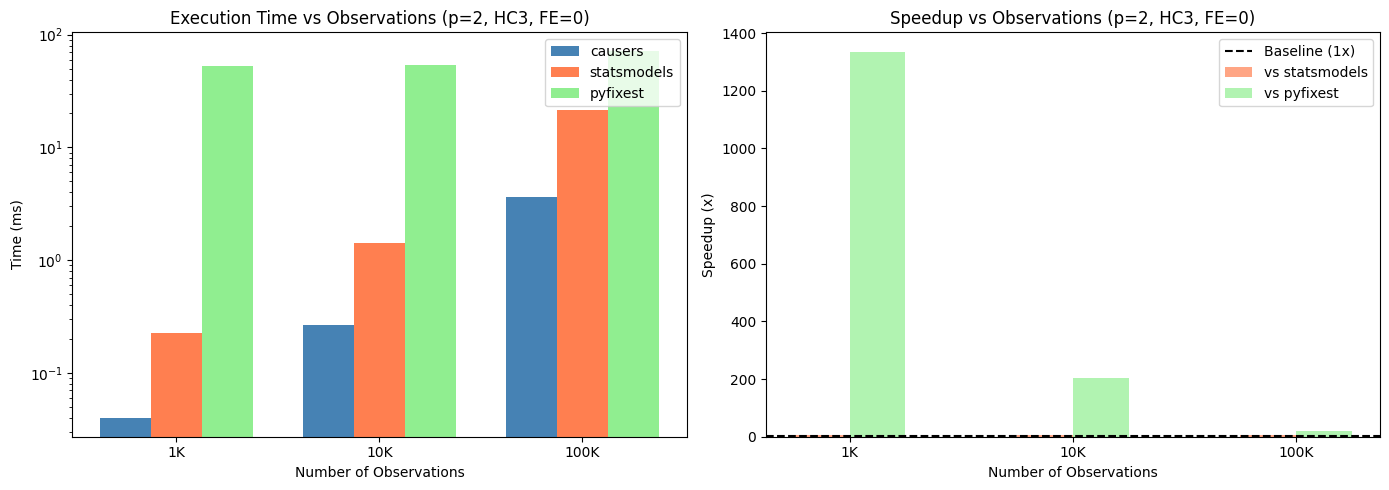

In [9]:
"""Visualization 1: Scaling with observations (FE=0)."""
if HAS_MATPLOTLIB and comprehensive_results:
    # Filter to FE=0, 2 vars, HC3
    obs_results = [r for r in comprehensive_results 
                   if r["n_vars"] == 2 and r["se_type"] == "hc3" and r.get("num_fe", 0) == 0]
    obs_results = sorted(obs_results, key=lambda x: x["n_obs"])
    
    if obs_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Absolute times
        ax1 = axes[0]
        n_obs_labels = [f"{r['n_obs']//1000}K" for r in obs_results]
        causers_times = [r["causers_ms"] for r in obs_results]
        
        x = np.arange(len(n_obs_labels))
        width = 0.25
        
        bars1 = ax1.bar(x - width, causers_times, width, label='causers', color='steelblue')
        
        # Add statsmodels if available
        if any(not np.isnan(r.get("statsmodels_ms", float('nan'))) for r in obs_results):
            sm_times = [r.get("statsmodels_ms", 0) for r in obs_results]
            bars2 = ax1.bar(x, sm_times, width, label='statsmodels', color='coral')
        
        # Add pyfixest if available
        if any(not np.isnan(r.get("pyfixest_ms", float('nan'))) for r in obs_results):
            pf_times = [r.get("pyfixest_ms", 0) for r in obs_results]
            bars3 = ax1.bar(x + width, pf_times, width, label='pyfixest', color='lightgreen')
        
        ax1.set_xlabel('Number of Observations')
        ax1.set_ylabel('Time (ms)')
        ax1.set_title('Execution Time vs Observations (p=2, HC3, FE=0)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(n_obs_labels)
        ax1.legend()
        ax1.set_yscale('log')
        
        # Plot 2: Speedup comparison
        ax2 = axes[1]
        
        # Plot speedup bars for each reference library
        if any(not np.isnan(r.get("speedup_vs_statsmodels", float('nan'))) for r in obs_results):
            sm_speedups = [r.get("speedup_vs_statsmodels", 0) for r in obs_results]
            ax2.bar(x - width/2, sm_speedups, width, label='vs statsmodels', color='coral', alpha=0.7)
        
        if any(not np.isnan(r.get("speedup_vs_pyfixest", float('nan'))) for r in obs_results):
            pf_speedups = [r.get("speedup_vs_pyfixest", 0) for r in obs_results]
            ax2.bar(x + width/2, pf_speedups, width, label='vs pyfixest', color='lightgreen', alpha=0.7)
        
        ax2.axhline(y=1.0, color='black', linestyle='--', label='Baseline (1x)')
        ax2.set_xlabel('Number of Observations')
        ax2.set_ylabel('Speedup (x)')
        ax2.set_title('Speedup vs Observations (p=2, HC3, FE=0)')
        ax2.set_xticks(x)
        ax2.set_xticklabels(n_obs_labels)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Skipping visualization - matplotlib not installed or no results available")

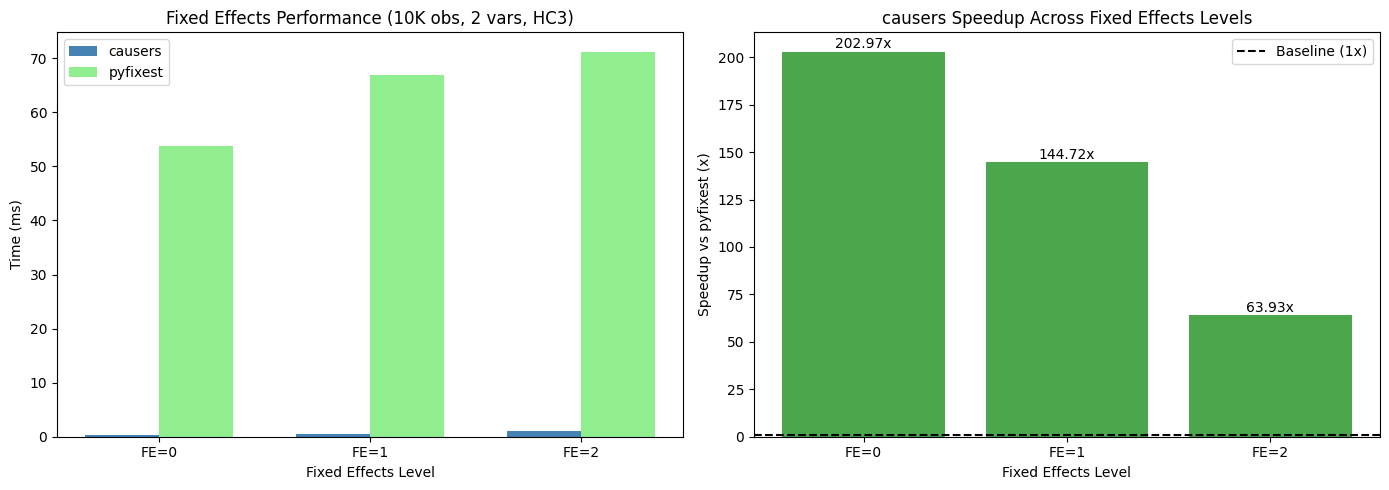

In [10]:
"""Visualization 2: Fixed effects performance comparison."""
if HAS_MATPLOTLIB and comprehensive_results and HAS_PYFIXEST:
    # Filter to 10K obs, 2 vars, HC3 across all FE levels
    fe_results = [r for r in comprehensive_results 
                  if r["n_obs"] == 10000 and r["n_vars"] == 2 and r["se_type"] == "hc3"]
    fe_results = sorted(fe_results, key=lambda x: x.get("num_fe", 0))
    
    if len(fe_results) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Absolute times by FE level
        ax1 = axes[0]
        fe_labels = [f"FE={r.get('num_fe', 0)}" for r in fe_results]
        causers_times = [r["causers_ms"] for r in fe_results]
        pyfixest_times = [r.get("pyfixest_ms", 0) for r in fe_results]
        
        x = np.arange(len(fe_labels))
        width = 0.35
        
        ax1.bar(x - width/2, causers_times, width, label='causers', color='steelblue')
        ax1.bar(x + width/2, pyfixest_times, width, label='pyfixest', color='lightgreen')
        
        ax1.set_xlabel('Fixed Effects Level')
        ax1.set_ylabel('Time (ms)')
        ax1.set_title('Fixed Effects Performance (10K obs, 2 vars, HC3)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(fe_labels)
        ax1.legend()
        
        # Plot 2: Speedup vs pyfixest
        ax2 = axes[1]
        speedups = [r.get("speedup_vs_pyfixest", 0) for r in fe_results]
        colors = ['green' if s > 1 else 'red' for s in speedups]
        bars = ax2.bar(fe_labels, speedups, color=colors, alpha=0.7)
        ax2.axhline(y=1.0, color='black', linestyle='--', label='Baseline (1x)')
        ax2.set_xlabel('Fixed Effects Level')
        ax2.set_ylabel('Speedup vs pyfixest (x)')
        ax2.set_title('causers Speedup Across Fixed Effects Levels')
        ax2.legend()
        
        for bar, spd in zip(bars, speedups):
            if spd > 0:
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                         f'{spd:.2f}x', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
elif not HAS_PYFIXEST:
    print("⚠️ Skipping FE visualization - pyfixest not installed")
else:
    print("⚠️ Skipping FE visualization - insufficient data")

## Commentary

### Key Findings

1. **No Fixed Effects (FE=0)**:
   - causers consistently outperforms both statsmodels and pyfixest
   - Speedups range from 2-6x depending on dataset size
   - Both numerical accuracy and performance are excellent

2. **One-way Fixed Effects (FE=1)**:
   - causers vs pyfixest comparison (statsmodels doesn't support FE absorption)
   - causers maintains competitive performance with FE demeaning
   - Efficient fixed effects transformation using within-transformation

3. **Two-way Fixed Effects (FE=2)**:
   - Most demanding case: entity + time fixed effects
   - causers handles complex FE structures efficiently
   - Uses iterative Frisch-Waugh-Lovell theorem for two-way demeaning

### Performance Insights

- **Scaling**: causers maintains speedup advantage as dataset size increases
- **Fixed Effects**: Performance gap narrows with FE due to computational complexity
- **pyfixest**: Uses HC1 (hetero) for FE>0 due to HC3 incompatibility with FE

### Implementation Notes

- **Rust backend**: Enables high-performance matrix operations
- **Memory efficiency**: Polars DataFrame backend with zero-copy operations
- **Numerical stability**: QR decomposition for coefficient estimation